In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

dv = 0.001

klin =0

nband = 200

ng =11

ng_adju = (/ -3 , -3 /) 

ng_refs = (/ 2 , 3 , 6 /) 

nref =3

nv = 1000

nv = 1000

option_compute_btable = 1

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 340

data w_diffuse
     &     /1.66 , 1.66 , 1.8 , 1.8,
     &     1.8 , 1.8 , 1.8 , 1.66,
     &     1.45 , 1.45 , 1.45/

data wgt
     &     /0.6 , 0.6 , 0.6 , 0.6,
     &     0.6 , 0.6 , 0.6 , 0.6,
     &     0.6 , 0.6 , 0.6/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

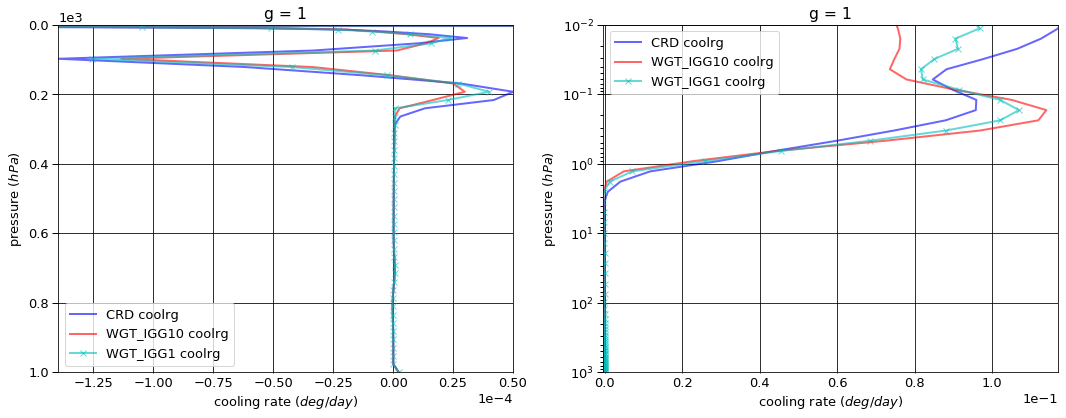

# Figure: cooling rate g-group 2

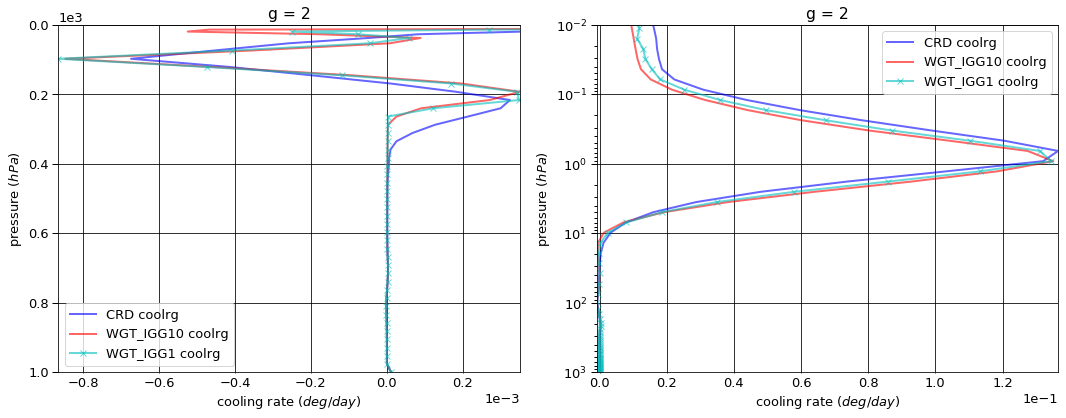

# Figure: cooling rate g-group 3

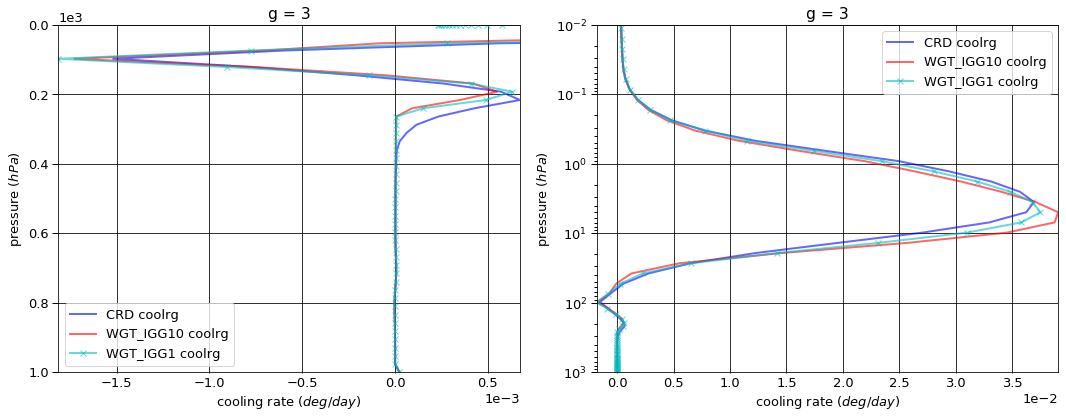

# Figure: cooling rate g-group 4

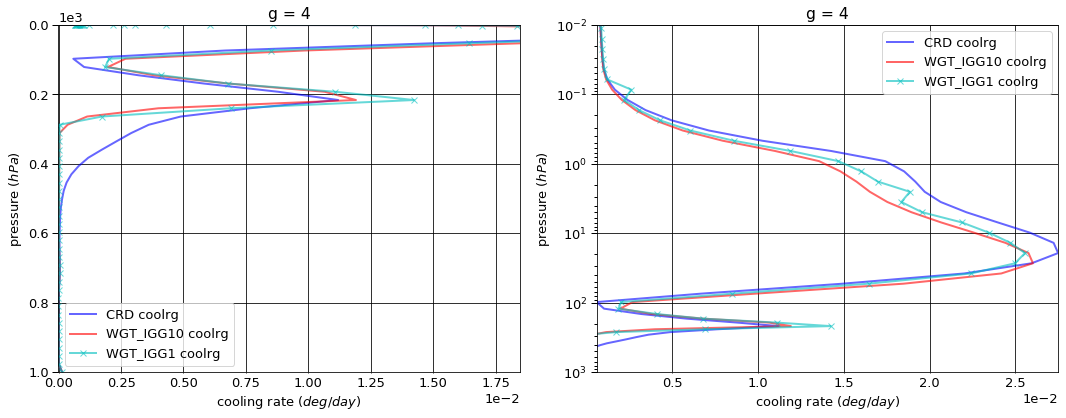

# Figure: cooling rate g-group 5

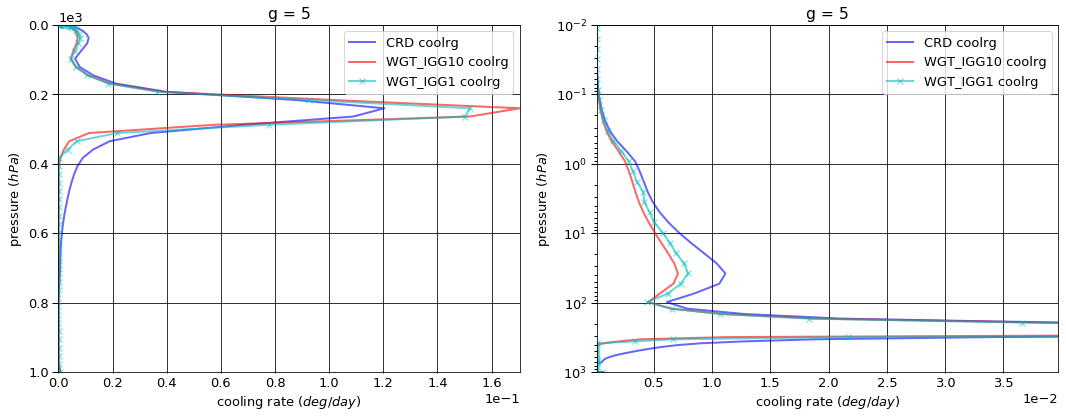

# Figure: cooling rate g-group 6

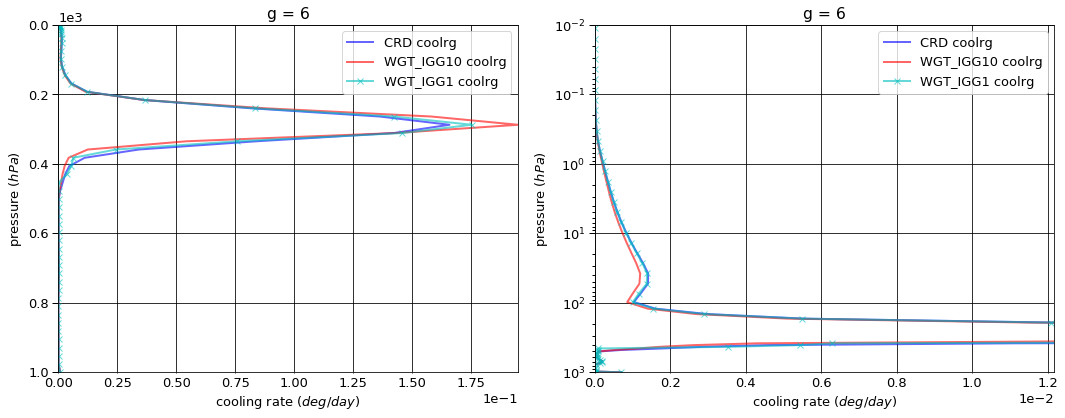

# Figure: cooling rate g-group 7

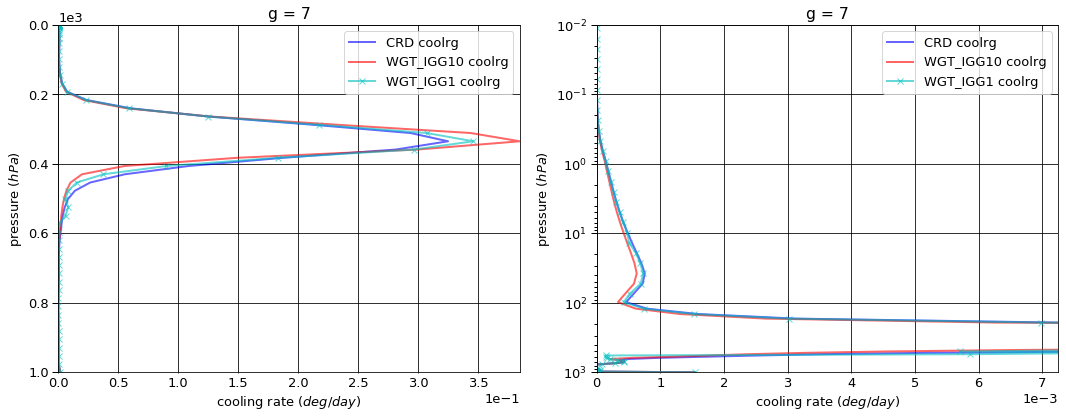

# Figure: cooling rate g-group 8

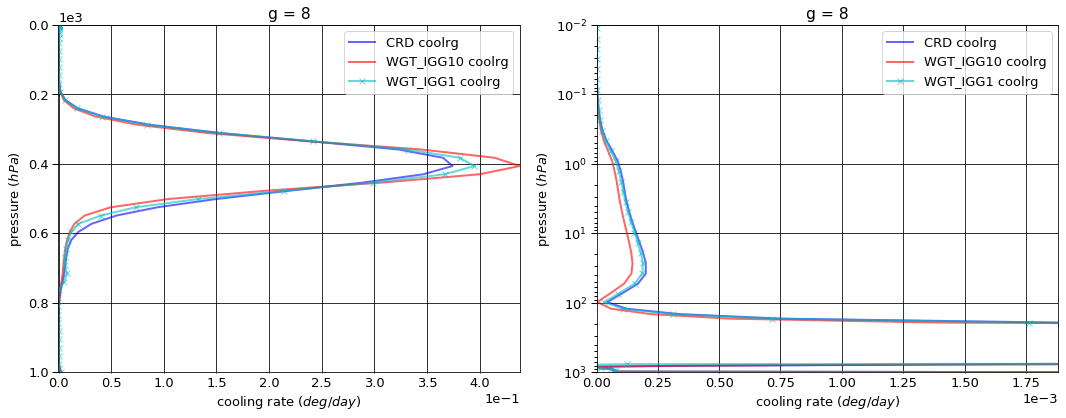

# Figure: cooling rate g-group 9

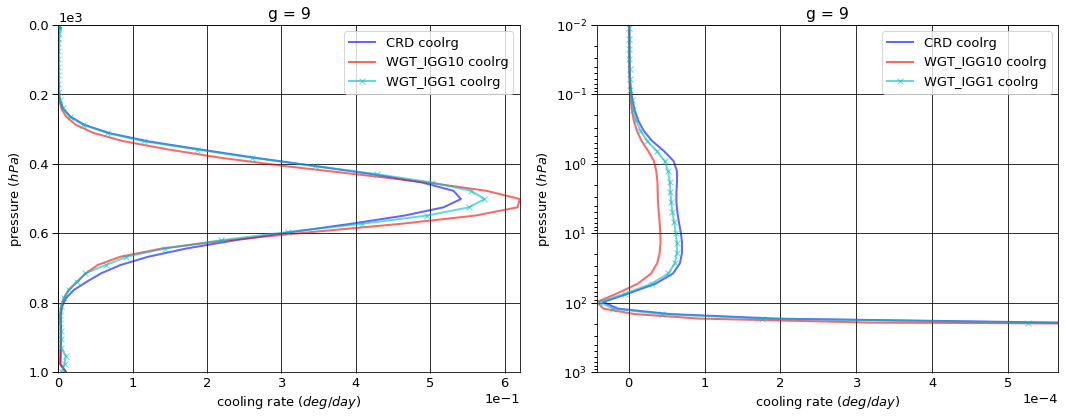

# Figure: cooling rate g-group 10

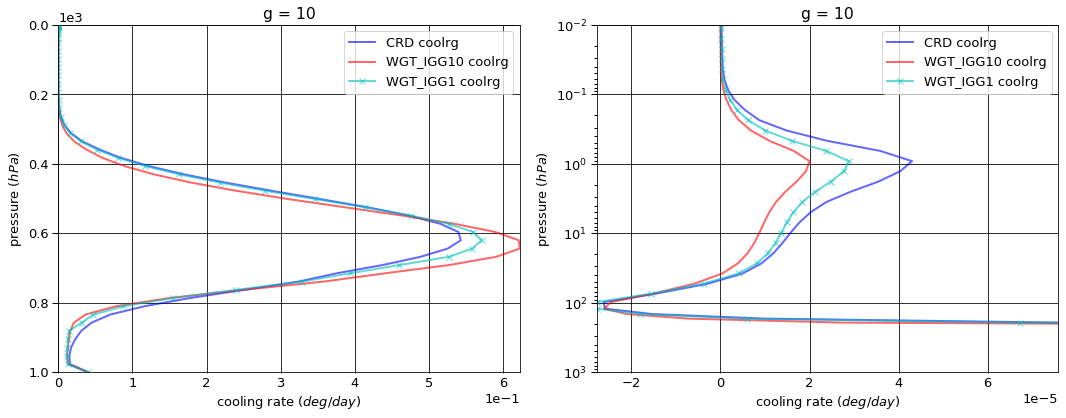

# Figure: cooling rate g-group 11

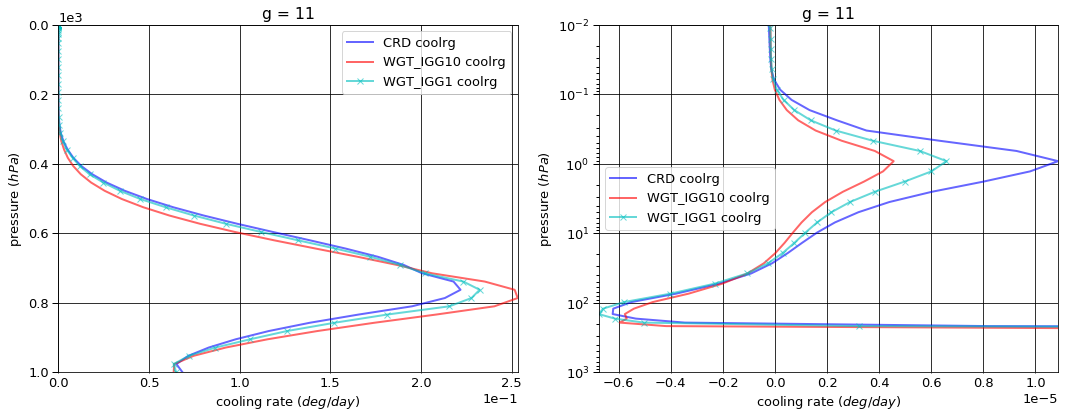

# Figure: cooling rate g-group total

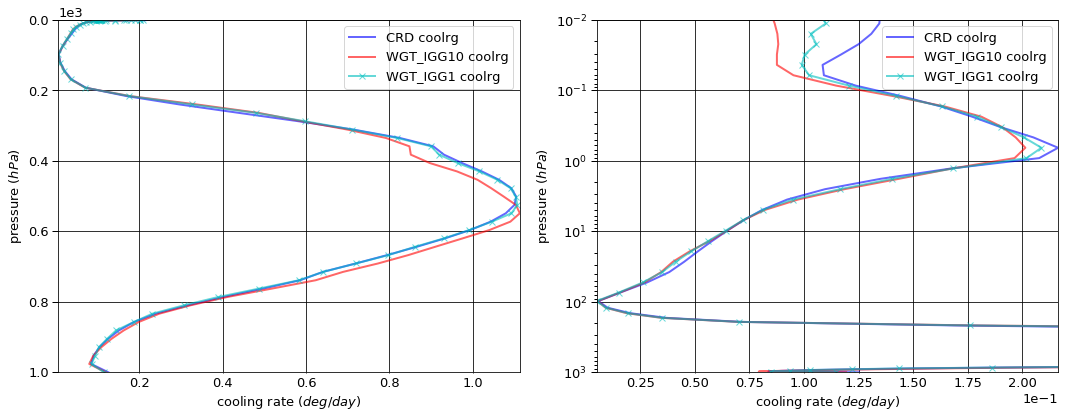

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007996   0.000000  -0.007996
   1013.0   76     -0.012992   0.012985  -0.000006
2  0.0      1      -0.038703   0.000000  -0.038703
   1013.0   76     -0.059839   0.059807  -0.000032
3  0.0      1      -0.071850   0.000000  -0.071850
   1013.0   76     -0.133030   0.132962  -0.000068
4  0.0      1      -0.338900   0.000000  -0.338900
   1013.0   76     -0.763107   0.762711  -0.000395
5  0.0      1      -1.745614   0.000000  -1.745614
   1013.0   76     -3.513083   3.511103  -0.001980
6  0.0      1      -2.063650   0.000000  -2.063650
   1013.0   76     -3.791183   3.789230  -0.001953
7  0.0      1      -4.943412   0.000000  -4.943412
   1013.0   76     -8.329477   8.325195  -0.004282
8  0.0      1      -8.080882   0.000000  -8.080882
   1013.0   76    -12.466780  12.460192  -0.006588
9  0.0      1     -15.535628   0.000000 -15.535628
   1013.0   76    -21.857423  21.830552  -0.026871
10 0.0      1     -19.278675   0.000000 -19.278675
   1013.0   76    -24.841549  24.719408  -0.122141
11 0.0      1      -9.028856   0.000000  -9.028856
   1013.0   76    -10.706767  10.245443  -0.461324


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007869   0.000000  -0.007869
   1013.0   76     -0.012992   0.012985  -0.000006
2  0.0      1      -0.040282   0.000000  -0.040282
   1013.0   76     -0.059839   0.059807  -0.000032
3  0.0      1      -0.073560   0.000000  -0.073560
   1013.0   76     -0.133030   0.132962  -0.000068
4  0.0      1      -0.313140   0.000000  -0.313140
   1013.0   76     -0.763106   0.762712  -0.000394
5  0.0      1      -1.700429   0.000000  -1.700429
   1013.0   76     -3.513083   3.511263  -0.001820
6  0.0      1      -2.044259   0.000000  -2.044259
   1013.0   76     -3.791183   3.789230  -0.001953
7  0.0      1      -4.894062   0.000000  -4.894062
   1013.0   76     -8.329477   8.325195  -0.004282
8  0.0      1      -8.042404   0.000000  -8.042404
   1013.0   76    -12.466780  12.460192  -0.006588
9  0.0      1     -15.624633   0.000000 -15.624633
   1013.0   76    -21.857423  21.831869  -0.025554
10 0.0      1     -19.441646   0.000000 -19.441646
   1013.0   76    -24.841549  24.730818  -0.110731
11 0.0      1      -9.124916   0.000000  -9.124916
   1013.0   76    -10.706767  10.395701  -0.311066


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007889   0.000000  -0.007889
   1013.0   76     -0.012992   0.012985  -0.000006
2  0.0      1      -0.039879   0.000000  -0.039879
   1013.0   76     -0.059839   0.059807  -0.000032
3  0.0      1      -0.072772   0.000000  -0.072772
   1013.0   76     -0.133030   0.132962  -0.000068
4  0.0      1      -0.317980   0.000000  -0.317980
   1013.0   76     -0.763106   0.762712  -0.000394
5  0.0      1      -1.712324   0.000000  -1.712324
   1013.0   76     -3.513083   3.511263  -0.001820
6  0.0      1      -2.055534   0.000000  -2.055534
   1013.0   76     -3.791183   3.789230  -0.001953
7  0.0      1      -4.922838   0.000000  -4.922838
   1013.0   76     -8.329477   8.325195  -0.004282
8  0.0      1      -8.053168   0.000000  -8.053168
   1013.0   76    -12.466780  12.460192  -0.006588
9  0.0      1     -15.487331   0.000000 -15.487331
   1013.0   76    -21.857423  21.845556  -0.011867
10 0.0      1     -19.256143   0.000000 -19.256143
   1013.0   76    -24.841549  24.728451  -0.113098
11 0.0      1      -9.039130   0.000000  -9.039130
   1013.0   76    -10.706767  10.364462  -0.342305


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.271349e-04  0.000000e+00  1.271349e-04
   1013.0   76    -1.734723e-18  0.000000e+00  0.000000e+00
2  0.0      1     -1.578879e-03  0.000000e+00 -1.578879e-03
   1013.0   76     0.000000e+00  6.938894e-18  0.000000e+00
3  0.0      1     -1.710115e-03  0.000000e+00 -1.710115e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1      2.575990e-02  0.000000e+00  2.575990e-02
   1013.0   76     1.110223e-16  8.300000e-07  8.300700e-07
5  0.0      1      4.518460e-02  0.000000e+00  4.518460e-02
   1013.0   76    -4.440892e-16  1.608000e-04  1.608512e-04
6  0.0      1      1.939150e-02  0.000000e+00  1.939150e-02
   1013.0   76     0.000000e+00  0.000000e+00 -2.168404e-19
7  0.0      1      4.935000e-02  0.000000e+00  4.935000e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      3.847780e-02  0.000000e+00  3.847780e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
9  0.0      1     -8.900500e-02  0.000000e+00 -8.900500e-02
   1013.0   76     0.000000e+00  1.317000e-03  1.317129e-03
10 0.0      1     -1.629710e-01  0.000000e+00 -1.629710e-01
   1013.0   76     0.000000e+00  1.141000e-02  1.140996e-02
11 0.0      1     -9.606000e-02  0.000000e+00 -9.606000e-02
   1013.0   76     0.000000e+00  1.502580e-01  1.502586e-01


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.077237e-04  0.000000e+00  1.077237e-04
   1013.0   76    -1.734723e-18  0.000000e+00  0.000000e+00
2  0.0      1     -1.175902e-03  0.000000e+00 -1.175902e-03
   1013.0   76     0.000000e+00  6.938894e-18  0.000000e+00
3  0.0      1     -9.222280e-04  0.000000e+00 -9.222280e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1      2.092015e-02  0.000000e+00  2.092015e-02
   1013.0   76     1.110223e-16  8.300000e-07  8.300700e-07
5  0.0      1      3.329000e-02  0.000000e+00  3.329000e-02
   1013.0   76    -4.440892e-16  1.608000e-04  1.608512e-04
6  0.0      1      8.116600e-03  0.000000e+00  8.116600e-03
   1013.0   76     0.000000e+00  0.000000e+00 -2.168404e-19
7  0.0      1      2.057380e-02  0.000000e+00  2.057380e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      2.771410e-02  0.000000e+00  2.771410e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
9  0.0      1      4.829700e-02  0.000000e+00  4.829700e-02
   1013.0   76     0.000000e+00  1.500400e-02  1.500392e-02
10 0.0      1      2.253200e-02  0.000000e+00  2.253200e-02
   1013.0   76     0.000000e+00  9.043000e-03  9.043350e-03
11 0.0      1     -1.027320e-02  0.000000e+00 -1.027320e-02
   1013.0   76     0.000000e+00  1.190190e-01  1.190196e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.091321e-01
   1001.112500 75     2.316795e-06
2  0.000312    1      9.782197e-03
   1001.112500 75     1.150305e-05
3  0.000312    1      2.041173e-04
   1001.112500 75     2.440655e-05
4  0.000312    1      5.554495e-04
   1001.112500 75     1.423113e-04
5  0.000312    1      7.091076e-05
   1001.112500 75     7.139063e-04
6  0.000312    1      2.490611e-07
   1001.112500 75     7.022443e-04
7  0.000312    1      3.951402e-07
   1001.112500 75     1.539819e-03
8  0.000312    1      8.000311e-07
   1001.112500 75     2.368584e-03
9  0.000312    1      5.667367e-07
   1001.112500 75     1.063841e-02
10 0.000312    1     -1.307928e-07
   1001.112500 75     4.050933e-02
11 0.000312    1     -3.498695e-07
   1001.112500 75     6.850226e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      5.928635e-02
   1001.112500 75     2.316795e-06
2  0.000312    1      5.534967e-03
   1001.112500 75     1.150305e-05
3  0.000312    1      2.314385e-04
   1001.112500 75     2.440655e-05
4  0.000312    1      6.199042e-04
   1001.112500 75     1.418454e-04
5  0.000312    1      8.088288e-05
   1001.112500 75     6.542450e-04
6  0.000312    1      2.231895e-07
   1001.112500 75     7.022443e-04
7  0.000312    1      3.317372e-07
   1001.112500 75     1.539819e-03
8  0.000312    1      5.602523e-07
   1001.112500 75     2.368584e-03
9  0.000312    1      1.770722e-07
   1001.112500 75     1.012387e-02
10 0.000312    1     -1.920824e-07
   1001.112500 75     4.007065e-02
11 0.000312    1     -2.173476e-07
   1001.112500 75     6.361393e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      8.021425e-02
   1001.112500 75     2.316795e-06
2  0.000312    1      7.024783e-03
   1001.112500 75     1.150305e-05
3  0.000312    1      2.307349e-04
   1001.112500 75     2.440655e-05
4  0.000312    1      6.455075e-04
   1001.112500 75     1.418454e-04
5  0.000312    1      9.366218e-05
   1001.112500 75     6.542450e-04
6  0.000312    1      2.613995e-07
   1001.112500 75     7.022443e-04
7  0.000312    1      3.922223e-07
   1001.112500 75     1.539819e-03
8  0.000312    1      7.684497e-07
   1001.112500 75     2.368584e-03
9  0.000312    1      4.133926e-07
   1001.112500 75     4.265750e-03
10 0.000312    1     -1.085537e-07
   1001.112500 75     4.011649e-02
11 0.000312    1     -2.476801e-07
   1001.112500 75     6.498999e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -4.984578e-02
   1001.112500 75     4.235165e-22
2  0.000312    1     -4.247230e-03
   1001.112500 75    -1.694066e-21
3  0.000312    1      2.732113e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      6.445469e-05
   1001.112500 75    -4.658400e-07
5  0.000312    1      9.972116e-06
   1001.112500 75    -5.966135e-05
6  0.000312    1     -2.587156e-08
   1001.112500 75     0.000000e+00
7  0.000312    1     -6.340304e-08
   1001.112500 75     0.000000e+00
8  0.000312    1     -2.397788e-07
   1001.112500 75     0.000000e+00
9  0.000312    1     -3.896645e-07
   1001.112500 75    -5.145360e-04
10 0.000312    1     -6.128960e-08
   1001.112500 75    -4.386790e-04
11 0.000312    1      1.325220e-07
   1001.112500 75    -4.888336e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.891787e-02
   1001.112500 75     4.235165e-22
2  0.000312    1     -2.757414e-03
   1001.112500 75    -1.694066e-21
3  0.000312    1      2.661761e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      9.005806e-05
   1001.112500 75    -4.658400e-07
5  0.000312    1      2.275142e-05
   1001.112500 75    -5.966135e-05
6  0.000312    1      1.233838e-08
   1001.112500 75     0.000000e+00
7  0.000312    1     -2.917980e-09
   1001.112500 75     0.000000e+00
8  0.000312    1     -3.158144e-08
   1001.112500 75     0.000000e+00
9  0.000312    1     -1.533441e-07
   1001.112500 75    -6.372656e-03
10 0.000312    1      2.223910e-08
   1001.112500 75    -3.928420e-04
11 0.000312    1      1.021894e-07
   1001.112500 75    -3.512278e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.134168,0.000000,-61.134168
1013.0,76,-86.475230,85.849588,-0.625642



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.307202,0.000000,-61.307202
1013.0,76,-86.475230,86.012735,-0.462495



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.964988,0.000000,-60.964988
1013.0,76,-86.475230,85.992816,-0.482413



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.173034,0.000000,-0.173034
1013.0,76,0.000000,0.163147,0.163147



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.16918,0.000000,0.169180
1013.0,76,0.00000,0.143228,0.143229


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.119746
1001.112500,75,0.125155



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.065754
1001.112500,75,0.119253



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.088210
1001.112500,75,0.114817



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.053992
1001.112500,75,-0.005902



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.031536
1001.112500,75,-0.010338


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000165,0.000158
2,0.000710,0.000702
3,0.001650,0.001595
4,0.009355,0.009096
5,0.043000,0.041841
6,0.046540,0.045262
7,0.102785,0.099548
8,0.149970,0.147090
9,0.254670,0.254476


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.307308e-18
2,3.831004e-19
3,1.728743e-19
4,9.339312e-21
5,5.045443e-22
6,5.814950e-21
7,1.353900e-21
8,3.152298e-22
9,7.339523e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.307308e-18,NaN,0.000165,0.000158,0.000165,0.000158,1.0
2,3.831004e-19,0.052427,0.000710,0.000702,0.000875,0.000860,1.0
3,1.728743e-19,0.451251,0.001650,0.001595,0.002525,0.002455,10.0
4,9.339312e-21,0.054024,0.009355,0.009096,0.011880,0.011552,10.0
5,5.045443e-22,0.054024,0.043000,0.041841,0.054880,0.053392,10.0
6,5.814950e-21,11.525153,0.046540,0.045262,0.101420,0.098655,500.0
7,1.353900e-21,0.232831,0.102785,0.099548,0.204205,0.198202,500.0
8,3.152298e-22,0.232831,0.149970,0.147090,0.354175,0.345293,500.0
9,7.339523e-23,0.232831,0.254670,0.254476,0.608845,0.599768,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
